<a href="https://colab.research.google.com/github/DiGyt/asrpy/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ASRpy usage Example
---

This notebook will provide a simple example how to apply the Artifact Subspace Reconstruction method to a MNE-Python raw object.
You should be able to run this notebook directly from your browser by clicking on the `Open in Colab` link above.

---


First you need to install [ASRpy](https://github.com/DiGyt/asrpy) in your Python environment. If you're not working from a Jupyter Notebook, paste the below line (without the `!`) into your command line.

In [1]:
!pip install asrpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.6 MB/s eta 0:00:00


Now, import all required libraries.

In [2]:
# import libraries
import mne
from mne.datasets import ssvep
from asrpy import ASR

Load a raw EEG recording and do some basic preprocessing (resampling, filtering).

In [3]:
# Load raw data
data_path = str(ssvep.data_path())
raw_fname = data_path + '/sub-02/ses-01/eeg/sub-02_ses-01_task-ssvep_eeg.vhdr'
raw = mne.io.read_raw_brainvision(raw_fname, preload=True, verbose=False)

# Set montage
montage = mne.channels.make_standard_montage('easycap-M1')
raw.set_montage(montage, verbose=False)

# downsample for faster computation
raw.resample(256)

# apply a highpass filter from 1 Hz upwards
raw.filter(1., None, fir_design='firwin')  # replace baselining with high-pass

# Construct epochs
event_id = {'12hz': 255, '15hz': 155}
events, _ = mne.events_from_annotations(raw, verbose=False)

# epoching time frame
tmin, tmax = -0.1, 1.5

# create an uncleaned average (for comparison purposes)
noisy_avg = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                           picks=None, baseline=None, preload=True,
                           verbose=False).average()

Using default location ~/mne_data for ssvep...
Creating ~/mne_data


100%|█████████████████████████████████████| 39.5M/39.5M [00:00<00:00, 10.4GB/s]
Unzipping contents of '/root/mne_data/ssvep_example_data.zip' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


## Use ASRpy with MNE raw objects.

ASRpy is implemented to work directly on MNE Raw data instances. As you can see below, you should be able to apply it to an MNE Raw object without any problems. If you want to fit your ASR on simple numpy arrays instead, please use `asrpy.asr_calibrate` and `asrpy.asr_process` instead.

In [4]:
# Apply the ASR
asr = ASR(sfreq=raw.info["sfreq"], cutoff=15)
asr.fit(raw)
raw = asr.transform(raw)

# Create an average using the cleaned data
clean_avg = mne.Epochs(raw, events, event_id, -0.1, 1.5, proj=False,
                picks=None, baseline=None, preload=True,
                verbose=False).average()

Done. Now we can plot the noisy vs. the clean data in order to compare them.

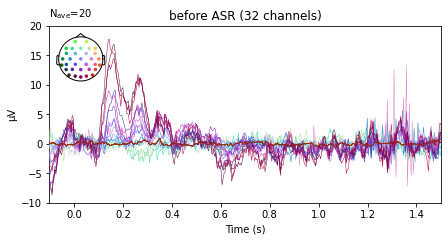

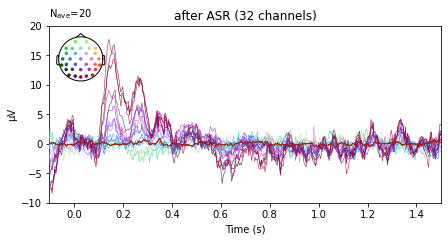

In [5]:
# set y axis limits
ylim = dict(eeg=[-10, 20])

# Plot image epoch before xdawn
noisy_avg.plot(spatial_colors=True, ylim=ylim,
               titles="before ASR")

# Plot image epoch before xdawn
clean_avg.plot(spatial_colors=True, ylim=ylim,
               titles="after ASR");

## Use ASRpy with numpy arrays.

If you are working with numpy arrays of EEG data (instead of MNE objects), you can use the `asr_calibrate` and `asr_process` functions to clean your data.

In [6]:
from asrpy import asr_calibrate, asr_process, clean_windows

# create a numpy array of EEG data from the MNE raw object
eeg_array = raw.get_data()

# extract the sampling frequency from the MNE raw object
sfreq = raw.info["sfreq"]

# (optional) make sure your asr is only fitted to clean parts of the data
pre_cleaned, _ = clean_windows(eeg_array, sfreq, max_bad_chans=0.1)

# fit the asr
M, T = asr_calibrate(pre_cleaned, sfreq, cutoff=15)

# apply it
clean_array = asr_process(eeg_array, sfreq, M, T)